# Openclassrooms PJ4 : modelisation notebook on simple randomly generated data

# Global variables and functions used in the notebook

In [2]:
%matplotlib inline

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

SAMPLED_DATA = True
#NB_SAMPLES = 10000
#NB_SAMPLES = 3000
NB_SAMPLES = 10000
LEARNING_CURVE_STEP_SIZE = 500 # Change that when you change NB_SAMPLES size

ALL_FEATURES = ['X_quant', 'X_qual', 'label']
MODEL1_2FEATS = ['X_quant', 'X_qual']
MODEL1_2FEATS_QUANTITATIVE = ['X_quant']
MODEL1_LABEL = 'label'

plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :
RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures


### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats



In [3]:
def qgrid_show(df):
    display(qgrid.show_grid(df, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 170}))

In [4]:
def load_data():
    # hhmm timed features formatted
    feats_hhmm = ['CRS_DEP_TIME',  'CRS_ARR_TIME']

    df = pd.read_csv(DATA_PATH_FILE_INPUT, sep=',', header=0, encoding='utf-8', low_memory=False, parse_dates=feats_hhmm)   
    
    # Drop outliers (low quantile data : extreme delays not enough represented)
    df.drop(index=df[(df['ARR_DELAY'] < df.ARR_DELAY.quantile(.01)) | (df['ARR_DELAY'] > df.ARR_DELAY.quantile(.99))].index, axis=0, inplace=True)
    
    return(df)

In [5]:
def custom_train_test_split_sample(df):
    from sklearn.model_selection import train_test_split
    
    if (SAMPLED_DATA == True):
        df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)
        #df = df.sample(NB_SAMPLES).copy(deep=True)
        df, df2 = train_test_split(df, train_size=NB_SAMPLES, random_state=42, shuffle = True, stratify = df_labels_discrete)
        
    df_labels_discrete = pd.cut(df['ARR_DELAY'], bins=50)
    
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42, shuffle = True, stratify = df_labels_discrete)
    #df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    
    df_train = df_train.copy()
    df_test = df_test.copy()

    '''
    # Old code: we sampled only training set. But that's a problem when you encounter values in test set (not sampled) that were not in training set
    if (SAMPLED_DATA == True):
        df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
        df = df.loc[df_train.index]
    '''   
    
    return df, df_train, df_test

In [6]:
def custom_train_test_split_sample_random(df):
    from sklearn.model_selection import train_test_split
    
    if (SAMPLED_DATA == True):
        df = df.sample(NB_SAMPLES).copy(deep=True)
        
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
    
    df_train = df_train.copy()
    df_test = df_test.copy()

    '''
    # Old code: we sampled only training set. But that's a problem when you encounter values in test set (not sampled) that were not in training set
    if (SAMPLED_DATA == True):
        df_train = df_train.sample(NB_SAMPLES).copy(deep=True)
        df = df.loc[df_train.index]
    '''   
    
    return df, df_train, df_test

In [7]:
def print_column_information(df, column_name):
    column_type = df.dtypes[column_name]
    print(f'Column {column_name}, type {column_type}\n')
    print('--------------------------')

    print(df[[column_name]].groupby(column_name).size().sort_values(ascending=False))
    print(df[column_name].unique())    
    print('\n')


In [8]:
def display_percent_complete(df):
    not_na = 100 - (df.isnull().sum() * 100 / len(df))
    not_na_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_complete': not_na}).sort_values(by='percent_complete', ascending=False)
    display(not_na_df)

In [9]:
def identify_features(df):
    all_features = ALL_FEATURES

    model1_features = MODEL1_FEATURES
    model1_label = MODEL1_LABEL
    
    quantitative_features = []
    qualitative_features = []
    features_todrop = []

    for feature_name in all_features:
        if (df[feature_name].dtype == 'object'):
            qualitative_features.append(feature_name)

        else:
            quantitative_features.append(feature_name)

    print(f'Quantitative features : {quantitative_features} \n')
    print(f'Qualitative features : {qualitative_features} \n')  
    
    return all_features, model1_features, model1_label, quantitative_features, qualitative_features

In [10]:
def save_or_load_search_params(grid_search, save_file_suffix):
    if (SAVE_GRID_RESULTS == True):
        #df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
        #df_grid_search_results.to_csv(GRIDSEARCH_CSV_FILE)

        df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
        df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
        df_grid_search_results.to_csv(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.csv')

        with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'wb') as f:
            pickle.dump(grid_search, f, pickle.HIGHEST_PROTOCOL)
            
        return(grid_search, df_grid_search_results)

    if (LOAD_GRID_RESULTS == True):
        if ((SAVE_GRID_RESULTS == True) or (RECOMPUTE_GRIDSEARCH == True)):
            print('Error : if want to load grid results, you should not have saved them or recomputed them before, or you will loose all your training data')

        else:
            with open(GRIDSEARCH_FILE_PREFIX + save_file_suffix + '.pickle', 'rb') as f:
                grid_search = pickle.load(f)

            df_grid_search_results = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["mean_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["std_test_score"], columns=["std_test_score"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_fit_time"], columns=["mean_fit_time"])],axis=1)
            df_grid_search_results = pd.concat([df_grid_search_results,pd.DataFrame(grid_search.cv_results_["mean_score_time"], columns=["mean_score_time"])],axis=1)
            
            return(grid_search, df_grid_search_results)

In [11]:
def evaluate_model(model, X_test, Y_test):
    Y_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_predict)
    rmse = np.sqrt(mse)
    print(f'RMSE : {rmse}')
    

In [12]:
def evaluate_model_MAE(model, X_test, Y_test, percentage, threshold):
    Y_predict = model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_predict)
    print(f'MAE : {mae}')
    
    Y_AE = np.abs(Y_predict- Y_test)
    
    

In [13]:
'''
This function returns the % of absolute errors of the model that are < threshold, percent of the time
'''

def evaluate_model_percent_threshold(model, X_test, Y_test, percent, threshold):
    Y_predict = model.predict(X_test)
    
    Y_AE = np.abs(Y_predict- Y_test)
    Y_AE_best = Y_AE[Y_AE <= Y_AE.quantile(percent)] # Take percent best error values (eliminate errors > Y_AE.quantile(percent))
    
    error_percent_threshold = (len(Y_AE_best[Y_AE_best < threshold]) / len(Y_AE_best)) * 100
    
    return (error_percent_threshold)
    

In [14]:
def minibatch_generate_indexes(df_train_transformed, step_size):
    nb_instances = df_train_transformed.shape[0]
    final_index = nb_instances - 1

    for m in range(int(nb_instances/step_size)):
        left_index = m*step_size
        right_index = m*step_size + step_size - 1

        yield((left_index, right_index))

    # Last step :
    yield((left_index + step_size, final_index))

In [15]:
def plot_learning_curves(model, X_train, X_test, y_train, y_test, step_size, evaluation_method='RMSE'):
    train_errors, val_errors = [], []
    
    minibatch_indexes = minibatch_generate_indexes(X_train, step_size)
    
    # Initiate progress bar
    #nb_instances = len(df_train_transformed)
    nb_instances = df_train_transformed.shape[0]
    nb_iter = int(nb_instances/step_size) + 1    
    progbar = tqdm(range(nb_iter))
    #cnt = 0
    print(f'Calculating learning curve for {nb_iter} iterations')
    
    for (left_index, right_index) in minibatch_indexes:
        model.fit(X_train[:right_index], y_train[:right_index])
        y_train_predict = model.predict(X_train[:right_index])
        y_test_predict = model.predict(X_test)
        
        if (evaluation_method == 'RMSE'):
            train_errors.append(mean_squared_error(y_train[:right_index], y_train_predict))
            val_errors.append(mean_squared_error(y_test, y_test_predict))
            
        elif (evaluation_method == 'MAE'):
            train_errors.append(mean_absolute_error(y_train[:right_index], y_train_predict))
            val_errors.append(mean_absolute_error(y_test, y_test_predict))            
        
        # Update progress bar
        progbar.update(1)
        #cnt += 1

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="test")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set iterations", fontsize=14) # not shown
    
    if (evaluation_method == 'RMSE'):
        plt.ylabel("RMSE", fontsize=14)              # not shown
        
    elif (evaluation_method == 'MAE'):
         plt.ylabel("MAE", fontsize=14)  

In [16]:
#minibatches = minibatch_generate_indexes(df_train_transformed)

In [17]:
def reset_data():
    df = load_data()
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)
    df, df_train, df_test = custom_train_test_split_sample(df)

    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)
    df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
    
    return df, df_train, df_test, df_train_transformed, df_test_transformed

def reset_data_old():
    df = load_data()
    all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)
    df, df_train, df_test = custom_train_test_split_sample(df)

    df_train_transformed = preparation_pipeline_meansort.fit_transform(df_train)
    df_train_transformed = prediction_pipeline_without_sparse.fit_transform(df_train_transformed)

    df_test_transformed = preparation_pipeline_meansort.transform(df_test)
    df_test_transformed = prediction_pipeline_without_sparse.transform(df_test_transformed)
    df_test_transformed.shape
    
    return df, df_train, df_test, df_train_transformed, df_test_transformed

In [18]:
from IPython.display import display, Markdown

def display_freq_table(df, col_names):
    for col_name in col_names:    
        effectifs = df[col_name].value_counts(bins=50)

        modalites = effectifs.index # l'index de effectifs contient les modalités


        tab = pd.DataFrame(modalites, columns = [col_name]) # création du tableau à partir des modalités
        tab["Nombre"] = effectifs.values
        tab["Frequence"] = tab["Nombre"] / len(df) # len(data) renvoie la taille de l'échantillon
        tab = tab.sort_values(col_name) # tri des valeurs de la variable X (croissant)
        tab["Freq. cumul"] = tab["Frequence"].cumsum() # cumsum calcule la somme cumulée
        
        display(Markdown('#### ' + col_name))
        display(tab)

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn import decomposition
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import statistics

from scipy import sparse

'''
Cette fonction fait un 1 hot encoding des features qui sont des catégories
Old function not used anymore
'''
    
def add_categorical_features_1hot(df, categorical_features_totransform):
    #df.drop(labels=categorical_features_totransform, axis=1, inplace=True)
    
    
    #df_encoded = pd.get_dummies(df, columns=categorical_features_totransform, sparse=True)
    
    for feature_totransform in categorical_features_totransform:
        print(f'Adding 1hot Feature : {feature_totransform}')
        
        print('First')
        df_transformed = df[feature_totransform].str.get_dummies().add_prefix(feature_totransform +'_')   
        
        #df_new = pd.get_dummies(df, columns=['ORIGIN'])
        
        
        
        
        #df.drop(labels=feature_totransform, axis=1, inplace=True)
        print('Second')
        del df[feature_totransform]
        
        print('Third')
        df = pd.concat([df, df_transformed], axis=1)
        
    return(df)


class HHMM_to_Minutes(BaseEstimator, TransformerMixin):
    def __init__(self, features_toconvert = ['CRS_DEP_TIME', 'CRS_ARR_TIME']):
        self.features_toconvert = features_toconvert
        return None
    
    def fit(self, df):      
        return self
    
    def transform(self, df):       
        for feature_toconvert in self.features_toconvert:
            print(f'Converting feature {feature_toconvert}\n')
            #print('1\n')
            df_concat = pd.concat([df[feature_toconvert].str.slice(start=0,stop=2, step=1),df[feature_toconvert].str.slice(start=2,stop=4, step=1)], axis=1).astype(int).copy(deep=True)
                    
            #print('2\n')
            df[feature_toconvert] = (df_concat.iloc[:, [0]] * 60 + df_concat.iloc[:, [1]])[feature_toconvert]
            del df_concat
            
            #print('3\n')
        
        return(df)

    
class HHMM_to_HH(BaseEstimator, TransformerMixin):
    def __init__(self, features_toconvert = ['CRS_DEP_TIME', 'CRS_ARR_TIME']):
        self.features_toconvert = features_toconvert
        return None
    
    def fit(self, df):      
        return self
    
    def transform(self, df):       
        for feature_toconvert in self.features_toconvert:
            print(f'Converting feature {feature_toconvert}\n')
            #print('1\n')

            df.loc[:, feature_toconvert] = df[feature_toconvert].str.slice(start=0,stop=2, step=1)
        
        return(df)
    
'''
class CategoricalFeatures1HotEncoder_old(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):
        # /!\ Array will not have the same shape if we fit an ensemble of samples that have less values than total dataset
        df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
        #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)
        print('type of df : ' + str(type(df_encoded)))
        return(df_encoded)
'''

class CategoricalFeatures1HotEncoder(BaseEstimator, TransformerMixin):
    #def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
    def __init__(self):
        #self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
        #self.df_encoded = None
    
    #def fit(self, df, labels=None):      
    def fit(self, df, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):      
        print('Fit data')
        self.categorical_features_totransform = categorical_features_totransform
        print('!! categorical_features_totransform' + str(self.categorical_features_totransform))

        if (self.categorical_features_totransform != None):
            for feature_name in self.categorical_features_totransform:
                df[feature_name] = df[feature_name].astype(str) # Convert features to str in case they are not already     
                self.all_feature_values[feature_name] = feature_name + '_' + df[feature_name].unique()
        
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)
        
        if (self.categorical_features_totransform != None):
            print('Transform data')
            
            print('1hot encode categorical features...')
            #df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=True)  # Sparse allows to gain memory. But then, standardscale must be with_mean=False
            df_encoded = pd.get_dummies(df, columns=self.categorical_features_totransform, sparse=False)

            # Get category values that were in fitted data, but that are not in data to transform 
            for feature_name, feature_values in self.all_feature_values.items():
                diff_columns = list(set(feature_values) - set(df_encoded.columns.tolist()))
                print(f'Column values that were in fitted data but not in current data: {diff_columns}')

                if (len(diff_columns) > 0):
                    print('Adding those column with 0 values to the DataFrme...')
                    # Create columns with 0 for the above categories, in order to preserve same matrix shape between train et test set
                    zeros_dict = dict.fromkeys(diff_columns, 0)
                    df_encoded = df_encoded.assign(**zeros_dict)
                    print('Columns in the dataframe now : ')
                    print(df_encoded.columns)

            print('type of df : ' + str(type(df_encoded)))
            return(df_encoded)

        else:
            return(df)

class Aggregate_then_GroupByMean_then_Sort_numericalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features_totransform=['ORIGIN', 'UNIQUE_CARRIER', 'DEST']):
        self.categorical_features_totransform = categorical_features_totransform
        self.fitted = False
        self.all_feature_values = {}
    
    def fit(self, df, labels=None):      
        print('Fit data')
        
        self.feature_maps = {}
        
        for feature_name in self.categorical_features_totransform:
            print(f'Fitting feature {feature_name}')
            # List all feature values ordered by mean delay
            list_feature_mean_ordered = df[['ARR_DELAY', feature_name]].groupby(feature_name).mean().sort_values(by='ARR_DELAY', ascending=True).index.tolist()
            
            # Generate a dictionary of feature values as keys and index as values
            self.feature_maps[feature_name] = {}
            self.feature_maps[feature_name]['list_feature_mean_ordered_dict'] = {list_feature_mean_ordered[i] : i for i in range(len(list_feature_mean_ordered))  }
            
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # BUG : we had to do that line of code in transform instead, not in fit (result is the same, no difference)
            #self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'] = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                  
        self.fitted = True
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            print('Launching fit first (if you see this message : ensure that you have passed training set as input, not test set)')
            self.fit(df)
        
        print('Encode categorical features...')
        
        for feature_name in self.categorical_features_totransform:
            print(f'Encoding feature {feature_name} ...')
            #print('Dictionnary : ' + str(self.feature_maps[feature_name]['list_feature_mean_ordered_dict']))
            
            # Replace each feature value by its index (the lowest the index, the lowest the mean delay is for this feature)
            list_feature_mean_ordered_mapper = lambda k : self.feature_maps[feature_name]['list_feature_mean_ordered_dict'][k]
                            
            #df[feature_name] = df.loc[:, feature_name].apply(self.feature_maps[feature_name]['list_feature_mean_ordered_mapper'])  # BUG (we had to use line below instead)
            df[feature_name] = df.loc[:, feature_name].apply(list_feature_mean_ordered_mapper)

        return(df)
    
    
class FeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_toselect = None):  # If None : every column is kept, nothing is done
        self.features_toselect = features_toselect
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):       
        if (self.features_toselect != None):
            filter_cols = [col for col in df if (col.startswith(tuple(self.features_toselect)))]
            
            filter_cols.sort()
            
            print("Features selected (in order): " + str(df[filter_cols].columns))
            
            df = df.loc[:, filter_cols]
            return(df)

        else:
            return(df)

'''
In order have less features globally: we Keep only features_tofilter that represent percent_tokeep% of total values
Features which values represent less than percent_tokeep% will be set "OTHERS" value instead of their real value
'''

class Filter_High_Percentile(BaseEstimator, TransformerMixin):
    def __init__(self, features_tofilter = ['ORIGIN', 'DEST'], percent_tokeep = 80):
        self.features_tofilter = features_tofilter
        self.percent_tokeep = percent_tokeep
        self.high_percentile = None
        self.low_percentile = None
    
    def fit(self, df, labels=None): 
        print('Fit high percentile filter...')
        for feature_tofilter in self.features_tofilter:
            # Get feature_tofilter values that represent 80% of data
            self.high_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() < self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()
            self.low_percentile = ((((df[[feature_tofilter]].groupby(feature_tofilter).size() / len(df)).sort_values(ascending=False)) * 100).cumsum() >= self.percent_tokeep).where(lambda x : x == True).dropna().index.values.tolist()

            total = len(df[feature_tofilter].unique())
            high_percentile_sum = len(self.high_percentile)
            low_percentile_sum = len(self.low_percentile)
            high_low_sum = high_percentile_sum + low_percentile_sum

            print(f'Total number of {feature_tofilter} values : {total}')
            print(f'Number of {feature_tofilter} high percentile (> {self.percent_tokeep}%) values : {high_percentile_sum}')
            print(f'Number of {feature_tofilter} low percentile values : {low_percentile_sum}')
            print(f'Sum of high percentile + low percentile values : {high_low_sum}')
        
        print('End of high percentile filter fit')
        return self
    
    def transform(self, df):       
        if (self.features_tofilter != None):
            print('Apply high percentile filter...')
            
            for feature_tofilter in self.features_tofilter:
                print(f'Apply filter on feature {feature_tofilter}')
                # To do for later : apply low_percentile specific to the feature, and not only last calculated low_percentile  (in our case it's the same percentile for ORIGIN and DEST so this is not a problem)
                df.loc[df[feature_tofilter].isin(self.low_percentile), feature_tofilter] = 'OTHERS'   
            
            return(df)    

        else:
            return(df)
        

    
class DenseToSparseConverter(BaseEstimator, TransformerMixin):
    def __init__(self):  # If None : every column is kept, nothing is done
        return None
    
    def fit(self, matrix, labels=None):      
        return self
    
    def transform(self, matrix):   
        return(sparse.csr_matrix(matrix))

    
'''
This class adds polynomial features in univariate way  (if feature X and n_degree 3 :  then it will add X², X³, and an intercept at the end)

Requires ndarray as input
'''    
class PolynomialFeaturesUnivariateAdder(BaseEstimator, TransformerMixin):
    def __init__(self, n_degrees=2):
        self.n_degrees = n_degrees
        self.fitted = False
    
    def fit(self, df, labels=None):
        self.fitted = True
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)

        nb_instances, n_features = df.shape
        df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)

        progbar = tqdm(range(n_features))
        print('Adding polynomial features')

        for feature_index in range(n_features):    
            df_1feature = df[:,feature_index]  # Reshape 

            for n_degree in range(self.n_degrees):
                df_poly = np.c_[df_poly, np.power(df_1feature, n_degree + 1)]

            progbar.update(1)

        # Add bias (intercept)
        df_poly = np.c_[df_poly, np.ones((len(df_poly), 1))]  # add x0 = 1 feature        
        
        return(df_poly)

'''
This class adds polynomial features in univariate way  (if feature X and n_degree 3 :  then it will add X², X³, and an intercept at the end)

Requires DataFrame as input
'''        
    
class PolynomialFeaturesUnivariateAdder_DataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, n_degrees=2):
        self.n_degrees = n_degrees
        self.fitted = False
    
    def fit(self, df, features_toadd=None):  
        print('fit')
        self.features_toadd = features_toadd
        print('Features to add :')
        print(self.features_toadd)
        self.fitted = True
        return self
    
    def transform(self, df):
        print('transform')
        if (self.fitted == False):
            self.fit(df)

        nb_instances, n_features = df.shape
        #df_poly = np.empty((nb_instances, 0)) # Create empty array of nb_instances line and 0 features yet (we'll concatenate polynomial features to it)
        #df_poly = pd.DataFrame(index=df.index,columns=None)
        
        progbar = tqdm(range(len(self.features_toadd)))
        print('Adding polynomial features')

        for column_name in self.features_toadd:    
            #df_1feature = df.loc[:, column_name]

            for n_degree in range(1, self.n_degrees):
                #df = pd.concat([df, np.power(df.loc[:, column_name], n_degree + 1)], axis=1)
                df = pd.concat([df, np.power(df[[column_name]], n_degree + 1).rename(columns={column_name : column_name+'_DEG'+str(n_degree+1)})], axis=1)

            progbar.update(1)

        # Add bias (intercept)
        #df_poly = pd.concat([df_poly, np.ones((len(df_poly), 1))])  # add x0 = 1 feature        
        #del df
        return(df)    
    
    
class StandardScalerMultiple_old(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fitted = False
    
    def fit(self, df, columns=None):              
        self.columns = columns
        self.scaler = StandardScaler()
  
        if (self.columns == None):
            return(df)
        else:
            self.scaler.fit(df[self.columns].to_numpy())            
        
        return self
    
    def transform(self, df):
        if (self.fitted == False):
            self.fit(df)
        
        if (self.columns == None):
            return(df)
        
        else:
            df[self.columns] = self.scaler.transform(df[self.columns].to_numpy())

        return(df)
        
class StandardScalerMultiple(BaseEstimator, TransformerMixin):
    def __init__(self, features_toscale=None):
        self.fitted = False
        self.columns = features_toscale
    
    def fit(self, df):              
        print('Fit Std scale multiple')
        self.scaler = StandardScaler()
  
        if (self.columns == None):
            self.fitted = True
            return(df)
        else:
            self.scaler.fit(df[self.columns].to_numpy())            
            self.fitted = True
        
        return self
    
    def transform(self, df):
        print('Transform Std scale multiple')
        if (self.fitted == False):
            self.fit(df)
        
        if (self.columns == None):
            return(df)
        
        else:
            df.loc[:, self.columns] = self.scaler.transform(df.loc[:, self.columns].to_numpy())

        return(df)
        

class MinMaxScalerMultiple(BaseEstimator, TransformerMixin):
    def __init__(self, features_toscale=None):
        self.fitted = False
        self.columns = features_toscale
    
    def fit(self, df):              
        print('Fit Min max scaler multiple')
        self.scaler = MinMaxScaler()
  
        if (self.columns == None):
            self.fitted = True
            return(df)
        else:
            self.scaler.fit(df[self.columns].to_numpy())            
            self.fitted = True
        
        return self
    
    def transform(self, df):
        print('Transform Min max scaler multiple')
        if (self.fitted == False):
            self.fit(df)
        
        if (self.columns == None):
            return(df)
        
        else:
            df.loc[:, self.columns] = self.scaler.transform(df.loc[:, self.columns].to_numpy())

        return(df)        
        
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features_totransform = None):  # If None : every column is kept, nothing is done
        self.features_toselect = features_toselect
    
    def fit(self, df, labels=None):      
        return self
    
    def transform(self, df):       
        if (self.features_toselect != None):
            filter_cols = [col for col in df if (col.startswith(tuple(self.features_toselect)))]
            
            filter_cols.sort()
            
            print("Features selected (in order): " + str(df[filter_cols].columns))
            
            df = df.loc[:, filter_cols]
            return(df)

        else:
            return(df)
 
        

preparation_pipeline_2feats_stdscale = Pipeline([
    #('filter_highpercentile', Filter_High_Percentile()),
    #('hour_extractor', HHMM_to_HH()),
    #('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()), 
    
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_2FEATS)),
    #('standardscaler', StandardScalerMultiple(features_toscale=MODEL1_2FEATS_QUANTITATIVE)),
])




# Data generation

In [20]:
np.random.randn(NB_SAMPLES, 1).max()

4.057564988210571

In [21]:
X_quant = 2 * np.random.rand(NB_SAMPLES, 1)
y = 4 + 3 * X_quant + np.random.randn(NB_SAMPLES, 1)

In [22]:
y.max()

12.857781617127888

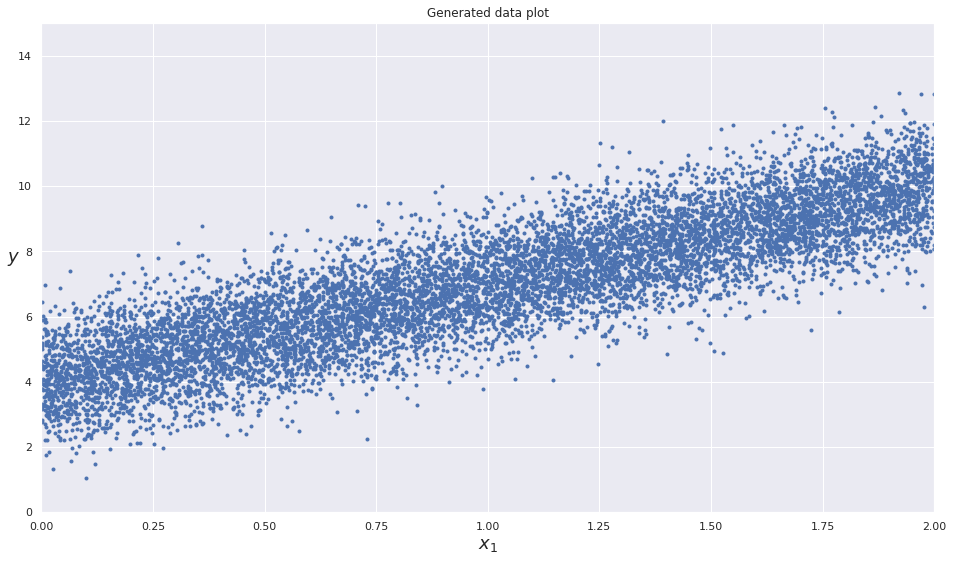

In [23]:
plt.plot(X_quant, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.title('Generated data plot')
plt.show()

In [24]:
df_y = pd.DataFrame(data=y)

In [25]:
y_qual = pd.cut(df_y.loc[:, 0], bins=range(0,15), right=True).astype(str).rename('X_qual')

In [26]:
y_qual

0         (5, 6]
1         (8, 9]
2         (8, 9]
3         (6, 7]
4         (7, 8]
          ...   
9995      (6, 7]
9996    (11, 12]
9997      (5, 6]
9998      (7, 8]
9999    (10, 11]
Name: X_qual, Length: 10000, dtype: object

In [27]:
#pd.concat([df, y_qual], axis=1, names=['a', 'b'])

In [28]:
df = pd.DataFrame(data={'X_quant' : X_quant[:, 0], 'X_qual' : y_qual, 'label': y[:, 0]})

In [29]:
df

,X_quant,X_qual,label
0,0.852484,"(5, 6]",5.904743
1,0.780846,"(8, 9]",8.295650
2,1.532112,"(8, 9]",8.995223
3,0.288664,"(6, 7]",6.167784
4,1.660054,"(7, 8]",7.433797
...,...,...,...
9995,0.198320,"(6, 7]",6.127911
9996,1.959088,"(11, 12]",11.097772
9997,0.970467,"(5, 6]",5.955902
9998,1.200527,"(7, 8]",7.775028


# Data transformation

In [30]:
ALL_FEATURES = ['X_quant', 'X_qual', 'label']
MODEL1_2FEATS = ['X_quant', 'X_qual']
MODEL1_2FEATS_QUANTITATIVE = ['X_quant']
MODEL1_LABEL = 'label'

MODEL1_FEATURES = ALL_FEATURES

In [31]:
all_features, model1_features, model1_label, quantitative_features, qualitative_features = identify_features(df)

Quantitative features : ['X_quant', 'label'] 

Qualitative features : ['X_qual'] 



In [32]:
preparation_pipeline_2feats_stdscale = Pipeline([
    ('categoricalfeatures_1hotencoder', CategoricalFeatures1HotEncoder()), 
    
    ('features_selector', FeaturesSelector(features_toselect=MODEL1_2FEATS)),
    #('standardscaler', StandardScalerMultiple(features_toscale=MODEL1_2FEATS_QUANTITATIVE)),
    ('standardscaler', MinMaxScalerMultiple(features_toscale=MODEL1_2FEATS_QUANTITATIVE)),
])

In [33]:
df, df_train, df_test = custom_train_test_split_sample_random(df)

In [34]:
#df_train_transformed = preparation_pipeline_meansort_standardscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=None)

In [35]:
df_train_transformed = preparation_pipeline_2feats_stdscale.fit_transform(df_train, categoricalfeatures_1hotencoder__categorical_features_totransform=qualitative_features)
#df_train_transformed = preparation_pipeline_2feats_stdscale.fit_transform(df_train)
df_test_transformed = preparation_pipeline_2feats_stdscale.transform(df_test)
DATA_LOADED = True
df_test_transformed.shape

Fit data
!! categorical_features_totransform['X_qual']
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['X_qual_(1, 2]', 'X_qual_(10, 11]', 'X_qual_(11, 12]',
       'X_qual_(12, 13]', 'X_qual_(2, 3]', 'X_qual_(3, 4]', 'X_qual_(4, 5]',
       'X_qual_(5, 6]', 'X_qual_(6, 7]', 'X_qual_(7, 8]', 'X_qual_(8, 9]',
       'X_qual_(9, 10]', 'X_quant'],
      dtype='object')
Fit Min max scaler multiple
Transform Min max scaler multiple
Transform data
1hot encode categorical features...
Column values that were in fitted data but not in current data: []
type of df : <class 'pandas.core.frame.DataFrame'>
Features selected (in order): Index(['X_qual_(1, 2]', 'X_qual_(10, 11]', 'X_qual_(11, 12]',
       'X_qual_(12, 13]', 'X_qual_(2, 3]', 'X_qual_(3, 4]', 'X_qual_(4, 5]',
       'X_qual_(5, 6]', 'X_qual_(6, 7]', 'X_qual_(7, 8]', 'X_qual_(8, 9]'

(1000, 13)

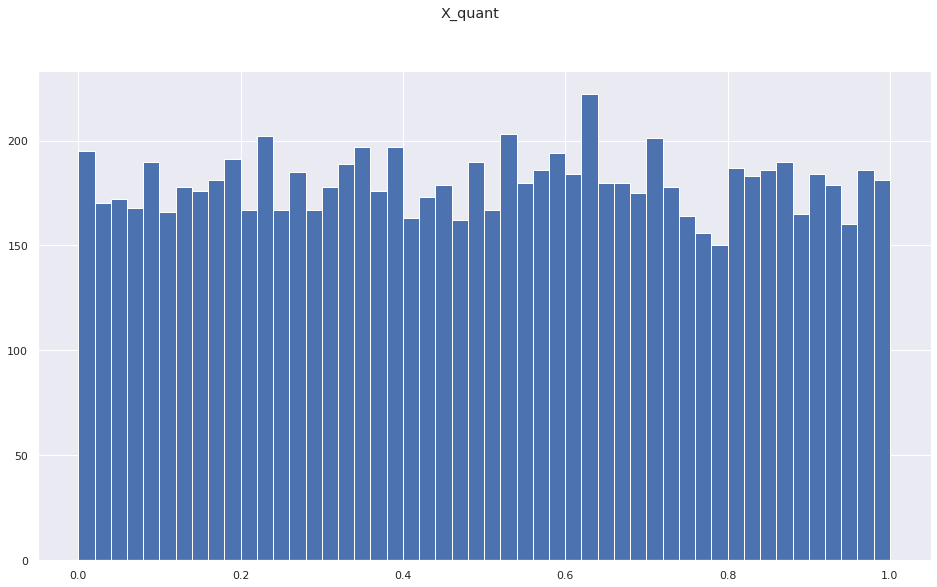

In [36]:
for feat_name in df_train_transformed.columns:
    if (feat_name in MODEL1_2FEATS_QUANTITATIVE):
        fig = plt.figure()
        fig.suptitle(feat_name)
        plt.hist(df_train_transformed[feat_name], bins=50)
        plt.plot()

In [37]:
df_train_transformed

,"X_qual_(1, 2]","X_qual_(10, 11]","X_qual_(11, 12]","X_qual_(12, 13]","X_qual_(2, 3]","X_qual_(3, 4]","X_qual_(4, 5]","X_qual_(5, 6]","X_qual_(6, 7]","X_qual_(7, 8]","X_qual_(8, 9]","X_qual_(9, 10]",X_quant
9101,0,0,0,0,0,1,0,0,0,0,0,0,0.030268
4765,0,0,0,0,0,0,0,0,1,0,0,0,0.135334
5620,0,0,0,0,0,0,0,0,0,0,1,0,0.728905
8689,0,0,0,0,0,0,0,0,0,1,0,0,0.442945
9397,0,0,0,0,0,0,0,0,0,0,0,1,0.981956
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621,0,0,0,0,0,0,0,0,0,0,0,1,0.968383
3769,0,0,0,0,0,0,0,0,1,0,0,0,0.765628
2636,0,0,0,0,0,0,0,1,0,0,0,0,0.594146
2791,0,0,0,0,0,0,0,0,0,0,1,0,0.587363


In [38]:
df_test_transformed

,"X_qual_(1, 2]","X_qual_(10, 11]","X_qual_(11, 12]","X_qual_(12, 13]","X_qual_(2, 3]","X_qual_(3, 4]","X_qual_(4, 5]","X_qual_(5, 6]","X_qual_(6, 7]","X_qual_(7, 8]","X_qual_(8, 9]","X_qual_(9, 10]",X_quant
4211,0,0,0,0,0,0,1,0,0,0,0,0,0.215520
6441,0,0,0,0,0,0,0,0,0,1,0,0,0.547846
3951,0,0,0,0,0,0,0,0,0,0,1,0,0.782222
981,0,0,0,0,0,0,0,1,0,0,0,0,0.163359
7464,0,0,0,0,0,0,0,0,1,0,0,0,0.732928
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8722,0,0,0,0,0,0,0,0,0,0,1,0,0.879023
2023,0,0,0,0,0,0,0,0,0,1,0,0,0.822613
3156,0,0,0,0,0,0,0,0,1,0,0,0,0.543919
1398,0,0,0,0,0,0,0,1,0,0,0,0,0.283705


## Linear regression

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(df_train_transformed, df_train[MODEL1_LABEL])

df_test_predictions = lin_reg.predict(df_test_transformed)

print("Evaluation on test set :")
evaluate_model(lin_reg, df_test_transformed, df_test[MODEL1_LABEL])

print('\n')

print("Evaluation on training set :")
evaluate_model(lin_reg, df_train_transformed, df_train[MODEL1_LABEL])

Evaluation on test set :
RMSE : 0.26736543639958715


Evaluation on training set :
RMSE : 0.27920319992070897


In [40]:
df_train_transformed[['X_quant']]

,X_quant
9101,0.030268
4765,0.135334
5620,0.728905
8689,0.442945
9397,0.981956
...,...
1621,0.968383
3769,0.765628
2636,0.594146
2791,0.587363


(array([  2.,   0.,   0.,   0.,  11.,   0.,   0.,   0.,  32.,  21.,   0.,
          0.,   0., 109.,   2.,   0.,   0.,  85.,  74.,   0.,   0.,  19.,
        137.,  23.,   0.,   0.,  60.,  88.,   0.,   0.,   6., 147.,  17.,
          0.,   0.,  21.,  82.,   0.,   0.,   1.,  51.,   0.,   0.,   0.,
          2.,   9.,   0.,   0.,   0.,   1.]),
 array([ 1.64135742,  1.85738525,  2.07341309,  2.28944092,  2.50546875,
         2.72149658,  2.93752441,  3.15355225,  3.36958008,  3.58560791,
         3.80163574,  4.01766357,  4.23369141,  4.44971924,  4.66574707,
         4.8817749 ,  5.09780273,  5.31383057,  5.5298584 ,  5.74588623,
         5.96191406,  6.17794189,  6.39396973,  6.60999756,  6.82602539,
         7.04205322,  7.25808105,  7.47410889,  7.69013672,  7.90616455,
         8.12219238,  8.33822021,  8.55424805,  8.77027588,  8.98630371,
         9.20233154,  9.41835938,  9.63438721,  9.85041504, 10.06644287,
        10.2824707 , 10.49849854, 10.71452637, 10.9305542 , 11.14658203,
 

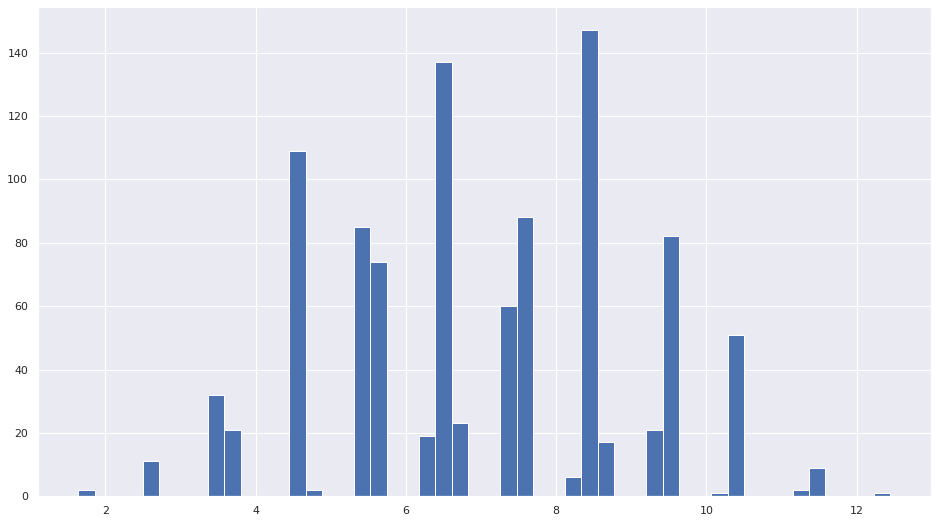

In [41]:
plt.hist(df_test_predictions, bins=50)

(array([ 2.,  0.,  0.,  0.,  6.,  5.,  6.,  7., 15., 10., 17., 23., 20.,
        25., 25., 33., 35., 27., 37., 31., 37., 46., 43., 27., 37., 30.,
        38., 32., 36., 20., 43., 35., 39., 28., 30., 21., 27., 24., 17.,
        15., 12., 15.,  8.,  4.,  4.,  3.,  2.,  1.,  1.,  1.]),
 array([ 1.74447561,  1.95453743,  2.16459925,  2.37466107,  2.58472289,
         2.7947847 ,  3.00484652,  3.21490834,  3.42497016,  3.63503197,
         3.84509379,  4.05515561,  4.26521743,  4.47527925,  4.68534106,
         4.89540288,  5.1054647 ,  5.31552652,  5.52558833,  5.73565015,
         5.94571197,  6.15577379,  6.3658356 ,  6.57589742,  6.78595924,
         6.99602106,  7.20608288,  7.41614469,  7.62620651,  7.83626833,
         8.04633015,  8.25639196,  8.46645378,  8.6765156 ,  8.88657742,
         9.09663924,  9.30670105,  9.51676287,  9.72682469,  9.93688651,
        10.14694832, 10.35701014, 10.56707196, 10.77713378, 10.98719559,
        11.19725741, 11.40731923, 11.61738105, 11.82744287,

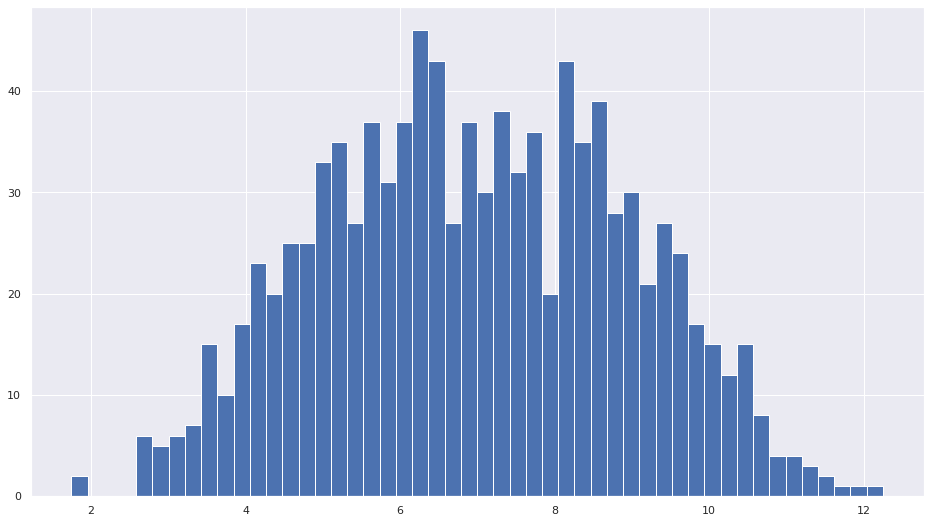

In [42]:
plt.hist(df_test[MODEL1_LABEL], bins=50)

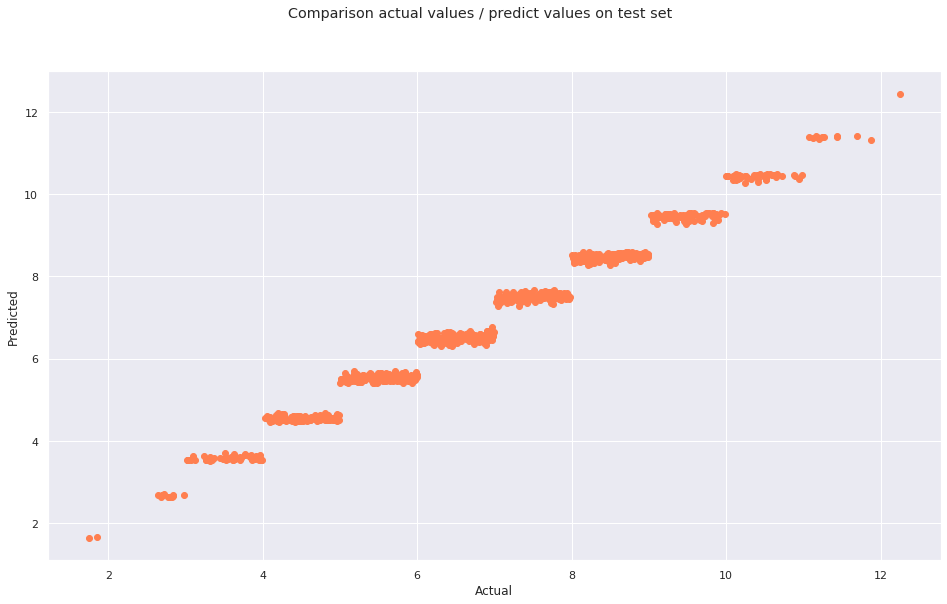

In [43]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on test set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_test[MODEL1_LABEL], df_test_predictions, color='coral', alpha=1)

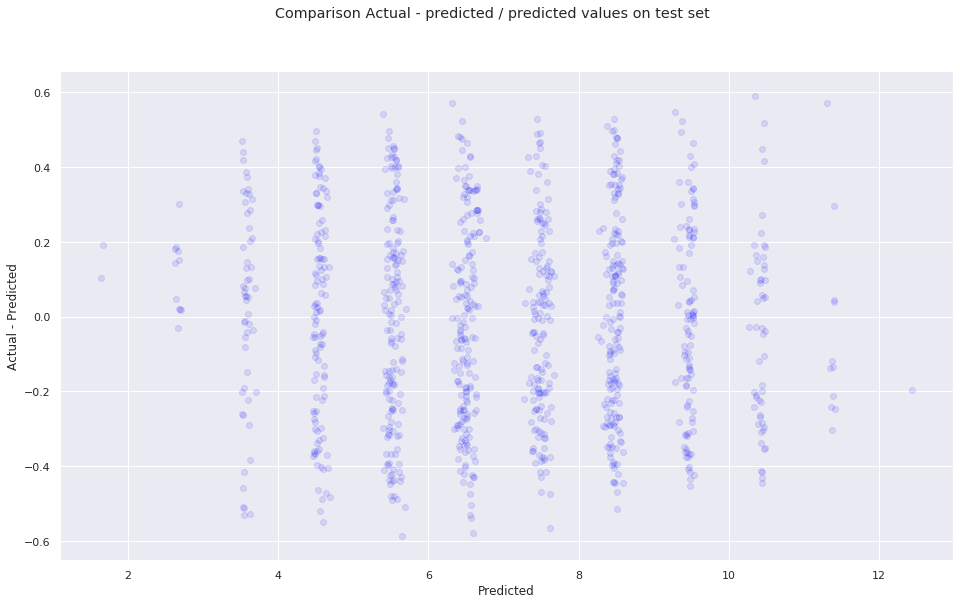

In [44]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[MODEL1_LABEL] - df_test_predictions, color='blue', alpha=0.1)

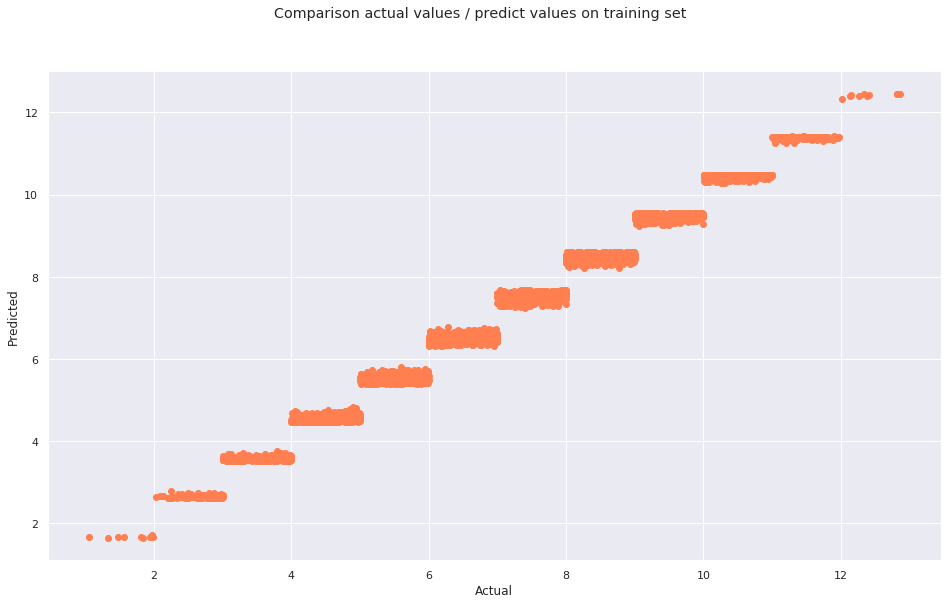

In [45]:
df_train_predictions = lin_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[MODEL1_LABEL], df_train_predictions, color='coral', alpha=1)

RMSE : 0.26736543639958715


Calculating learning curve for 19 iterations


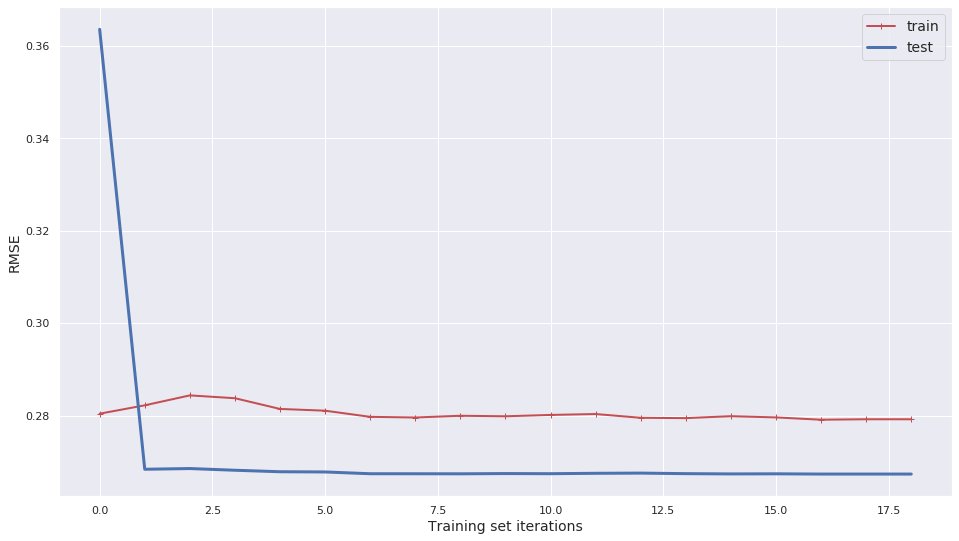

In [46]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = lin_reg.predict(df_test_transformed)
    evaluate_model(lin_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(lin_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [47]:
lin_reg.coef_

array([-9.79495693e+11, -9.79495693e+11, -9.79495693e+11, -9.79495693e+11,
       -9.79495693e+11, -9.79495693e+11, -9.79495693e+11, -9.79495693e+11,
       -9.79495693e+11, -9.79495693e+11, -9.79495693e+11, -9.79495693e+11,
        4.60358008e-01])

In [48]:
coef_feature_importances = (abs(lin_reg.coef_) / (abs(lin_reg.coef_).sum()))

In [49]:
coef_feature_importances.sum()

1.0

In [50]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : coef_feature_importances})

In [51]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

,Feature name,Feature importance,Feature importance
0,"X_qual_(1, 2]",8.333333e-02,0.083333
4,"X_qual_(2, 3]",8.333333e-02,0.166667
5,"X_qual_(3, 4]",8.333333e-02,0.250000
6,"X_qual_(4, 5]",8.333333e-02,0.333333
7,"X_qual_(5, 6]",8.333333e-02,0.416667
8,"X_qual_(6, 7]",8.333333e-02,0.500000
9,"X_qual_(7, 8]",8.333333e-02,0.583333
10,"X_qual_(8, 9]",8.333333e-02,0.666667
11,"X_qual_(9, 10]",8.333333e-02,0.750000
1,"X_qual_(10, 11]",8.333333e-02,0.833333


## Random forest

In [52]:
%%time
from sklearn.ensemble import RandomForestRegressor

if (EXECUTE_INTERMEDIATE_MODELS == True):
    random_reg = RandomForestRegressor(n_estimators=500, max_depth=500, n_jobs=-1, random_state=42)
    random_reg.fit(df_train_transformed, df_train[model1_label])

CPU times: user 14 s, sys: 506 ms, total: 14.5 s
Wall time: 5.93 s


In [53]:
from sklearn.model_selection import GridSearchCV

if (RECOMPUTE_GRIDSEARCH == True):
    param_grid = {
            'n_estimators':  [10, 100, 200, 500, 1000],
            'max_depth': [10, 100, 200, 500, 1000],
            'max_features': [2, 5, 13],
            'max_leaf_nodes': [2, 10, 100, None],
            'criterion': ['mse', 'mae'],
        }

    grid_search = GridSearchCV(random_reg, param_grid, cv=5, verbose=2, error_score=np.nan, scoring='neg_mean_squared_error')
    grid_search.fit(df_train_transformed, df_train[model1_label])

### Basic random forest evaluation

In [54]:
print("Evaluation on test set :")
evaluate_model(random_reg, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(random_reg, df_train_transformed, df_train[model1_label])

Evaluation on test set :
RMSE : 0.3261257712669207


Evaluation on training set :
RMSE : 0.1258766109340252


In [137]:
error_90p_02 = evaluate_model_percent_threshold(random_reg, df_test_transformed, df_test[model1_label], 0.9, 0.1)

In [140]:
print(f'{error_90p_02}% predictions have error below 0.1,  90% of the time')

26.0% predictions have error below 0.1,  90% of the time


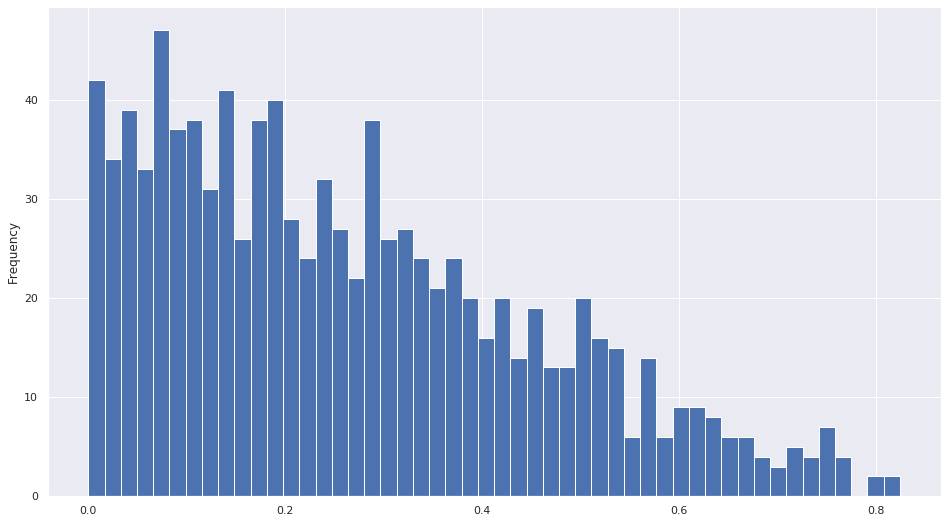

In [58]:
Y_AE.plot.hist(bins=50)

In [59]:
df_test_predictions = random_reg.predict(df_test_transformed)

In [60]:
df_train_predictions = random_reg.predict(df_train_transformed)

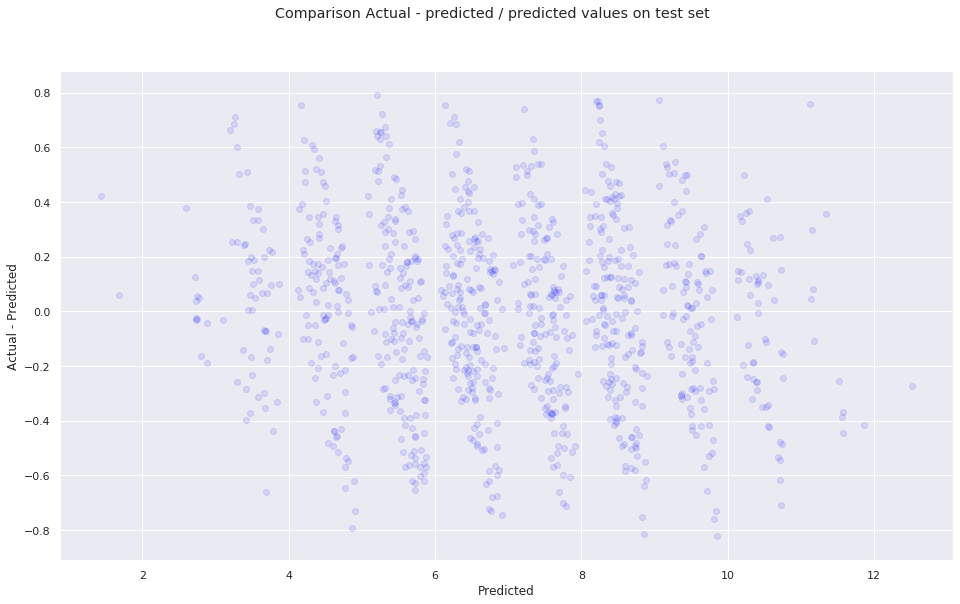

In [61]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

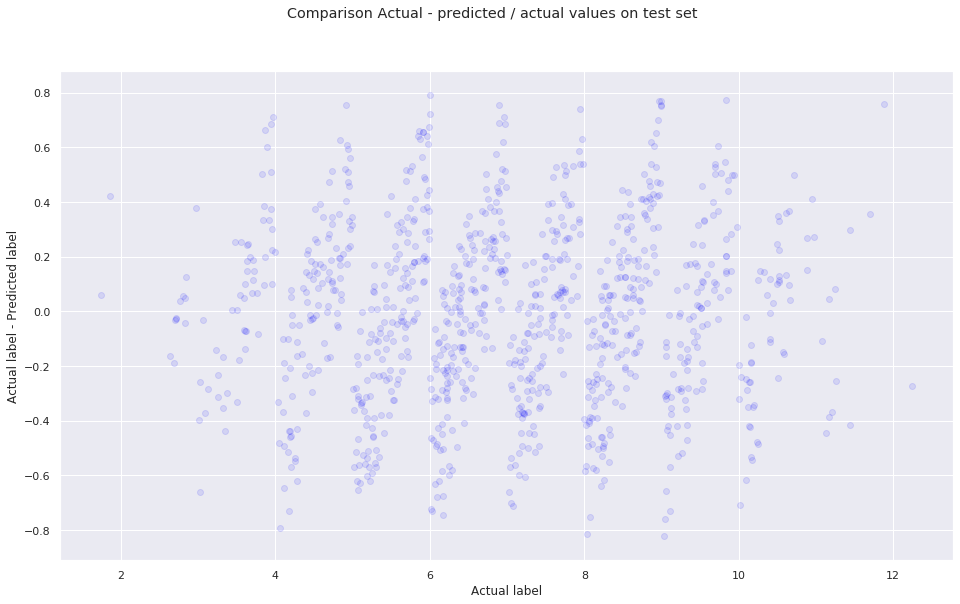

In [62]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

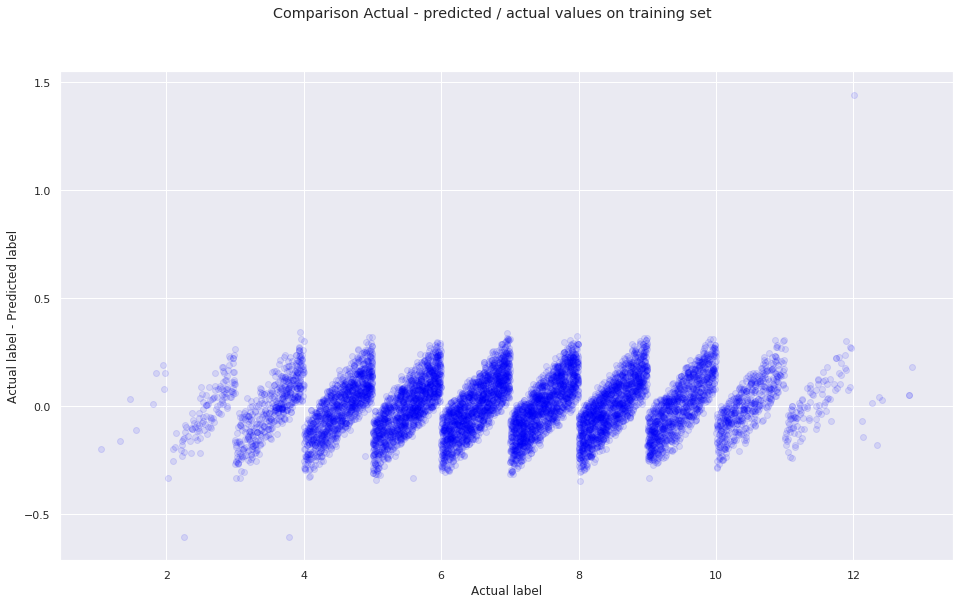

In [63]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / actual values on training set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

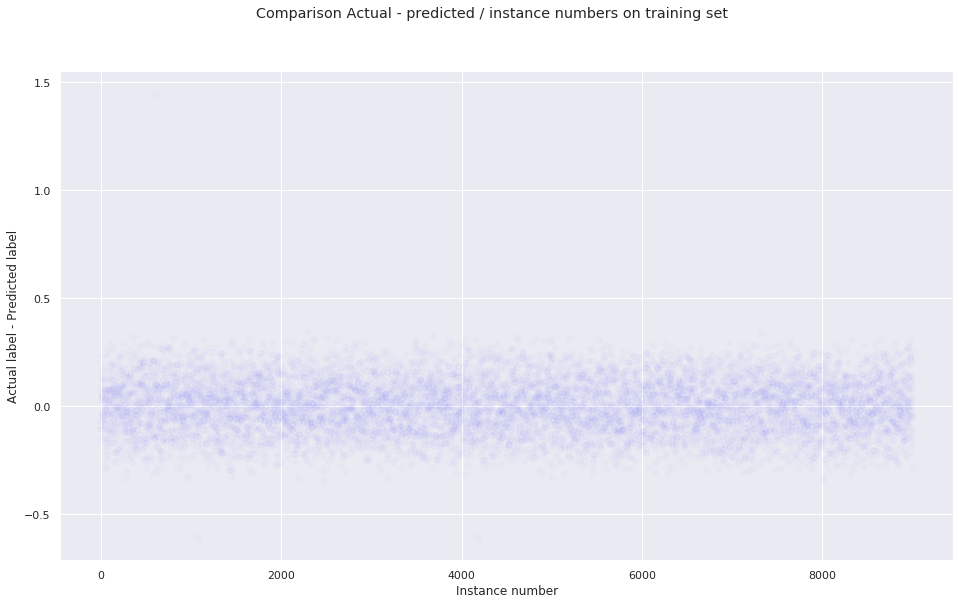

In [64]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
    plt.xlabel("Instance number")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.01)

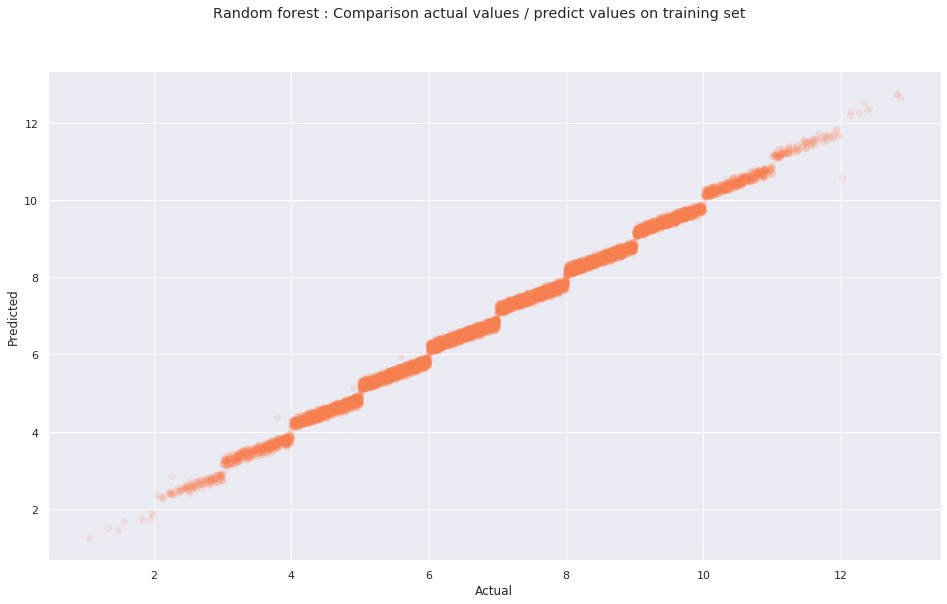

In [65]:
df_train_predictions = random_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Random forest : Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

RMSE : 0.3261257712669207


Calculating learning curve for 19 iterations


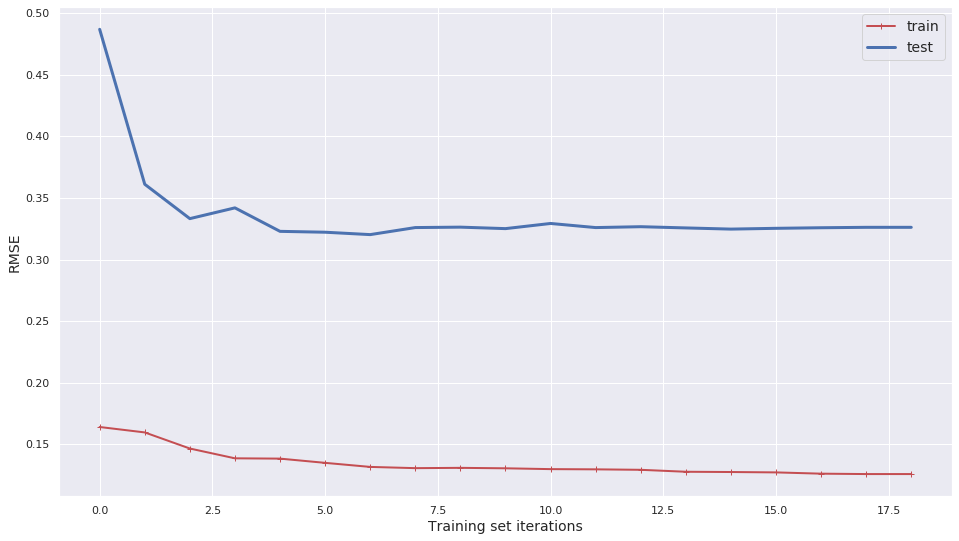

In [66]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(random_reg, df_test_transformed, df_test[model1_label])
    plot_learning_curves(random_reg, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [67]:
pd.set_option('display.max_rows', 200)

In [68]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : random_reg.feature_importances_})

In [69]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

,Feature name,Feature importance,Feature importance
12,X_quant,0.722684,0.722684
6,"X_qual_(4, 5]",0.042723,0.765407
7,"X_qual_(5, 6]",0.036602,0.802009
5,"X_qual_(3, 4]",0.029090,0.831099
8,"X_qual_(6, 7]",0.028630,0.859729
11,"X_qual_(9, 10]",0.027387,0.887116
1,"X_qual_(10, 11]",0.025160,0.912276
9,"X_qual_(7, 8]",0.020913,0.933189
4,"X_qual_(2, 3]",0.020260,0.953448
10,"X_qual_(8, 9]",0.019230,0.972678


In [70]:
random_reg.feature_importances_

array([0.00429798, 0.02515964, 0.01816593, 0.00485828, 0.02025966,
       0.02909017, 0.04272259, 0.03660193, 0.0286302 , 0.0209128 ,
       0.0192295 , 0.02738726, 0.72268406])

In [71]:
random_reg.feature_importances_.cumsum()

array([0.00429798, 0.02945762, 0.04762355, 0.05248183, 0.07274149,
       0.10183165, 0.14455424, 0.18115617, 0.20978638, 0.23069918,
       0.24992868, 0.27731594, 1.        ])

In [72]:
df[df['X_qual'].isnull()]

,X_quant,X_qual,label


### Best random forest evaluation

In [73]:
if ((SAVE_GRID_RESULTS == False) and (LOAD_GRID_RESULTS == True)):
    grid_search = None
    
grid_search, df_grid_search_results = save_or_load_search_params(grid_search, 'basicdata_20200411')

In [74]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
                      max_features=2, max_leaf_nodes=100,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [75]:
pd.set_option('display.max_rows', 1000)
df_grid_search_results.sort_values(by='mean_test_score', ascending=False)

,criterion,max_depth,max_features,max_leaf_nodes,n_estimators,mean_test_score,std_test_score,mean_fit_time,mean_score_time
254,mse,1000,2,100.0,1000,-0.094331,0.011824,0.976606,0.244151
74,mse,100,2,100.0,1000,-0.094331,0.011824,0.906062,0.304712
134,mse,200,2,100.0,1000,-0.094331,0.011824,0.910212,0.284437
194,mse,500,2,100.0,1000,-0.094331,0.011824,0.995386,0.264575
193,mse,500,2,100.0,500,-0.094333,0.012022,0.497821,0.163728
253,mse,1000,2,100.0,500,-0.094333,0.012022,0.492228,0.184331
73,mse,100,2,100.0,500,-0.094333,0.012022,0.459554,0.184014
133,mse,200,2,100.0,500,-0.094333,0.012022,0.471886,0.163888
252,mse,1000,2,100.0,200,-0.094571,0.012286,0.233573,0.103781
192,mse,500,2,100.0,200,-0.094571,0.012286,0.223242,0.105070


In [76]:
print("Evaluation on test set :")
evaluate_model(grid_search.best_estimator_, df_test_transformed, df_test[model1_label])

print('\n')

print("Evaluation on training set :")
evaluate_model(grid_search.best_estimator_, df_train_transformed, df_train[model1_label])

Evaluation on test set :


ValueError: Number of features of the model must match the input. Model n_features is 14 and input n_features is 13 

In [ ]:
df_test_predictions = grid_search.best_estimator_.predict(df_test_transformed)

In [ ]:
df_train_predictions = grid_search.best_estimator_.predict(df_train_transformed)

In [ ]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Predicted")
    plt.ylabel("Actual - Predicted")
    plt.scatter(df_test_predictions, df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [ ]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on test set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_test[model1_label], df_test[model1_label] - df_test_predictions, color='blue', alpha=0.1)

In [ ]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / predicted values on training set')
    plt.xlabel("Actual label")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(df_train[model1_label], df_train[model1_label] - df_train_predictions, color='blue', alpha=0.1)

In [ ]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Comparison Actual - predicted / instance numbers on training set')
    plt.xlabel("Instance number")
    plt.ylabel("Actual label - Predicted label")
    plt.scatter(range(df_train.shape[0]), df_train[model1_label] - df_train_predictions, color='blue', alpha=0.01)

In [ ]:
df_train_predictions = random_reg.predict(df_train_transformed)

if (EXECUTE_INTERMEDIATE_MODELS == True):
    fig = plt.figure()
    fig.suptitle('Random forest : Comparison actual values / predict values on training set')
    plt.ylabel("Predicted")
    plt.xlabel("Actual")
    plt.scatter(df_train[model1_label], df_train_predictions, color='coral', alpha=0.1)

In [ ]:
if (EXECUTE_INTERMEDIATE_MODELS == True):
    df_test_predictions = random_reg.predict(df_test_transformed)
    evaluate_model(grid_search.best_estimator_, df_test_transformed, df_test[model1_label])
    plot_learning_curves(grid_search.best_estimator_, df_train_transformed, df_test_transformed, df_train[model1_label], df_test[model1_label], LEARNING_CURVE_STEP_SIZE)

In [ ]:
pd.set_option('display.max_rows', 200)

In [ ]:
df_feature_importances = pd.DataFrame(data = {'Feature name' : df_train_transformed.columns, 'Feature importance' : grid_search.best_estimator_.feature_importances_})

In [ ]:
pd.concat([df_feature_importances.sort_values(by='Feature importance', ascending=False), \
           df_feature_importances[['Feature importance']].sort_values(by='Feature importance', ascending=False).cumsum()], axis=1)

In [ ]:
grid_search.best_estimator_.feature_importances_

In [ ]:
grid_search.best_estimator_.feature_importances_.cumsum()

In [ ]:
df[df['X_qual'].isnull()]